### [The Supertrend — Implementing, Screening & Backtesting in Python](https://medium.datadriveninvestor.com/the-supertrend-implementing-screening-backtesting-in-python-70e8f88f383d)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

In [2]:
def Supertrend(df, atr_period, multiplier):
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    #df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
            
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        # 根據趨勢方向刪除波段以進行可視化
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    
    
atr_period = 34
atr_multiplier = 3.0

symbol = 'spy'
df = yf.download(symbol, start='2020-01-01')
supertrend = Supertrend(df, atr_period, atr_multiplier)
df = df.join(supertrend)

[*********************100%***********************]  1 of 1 completed


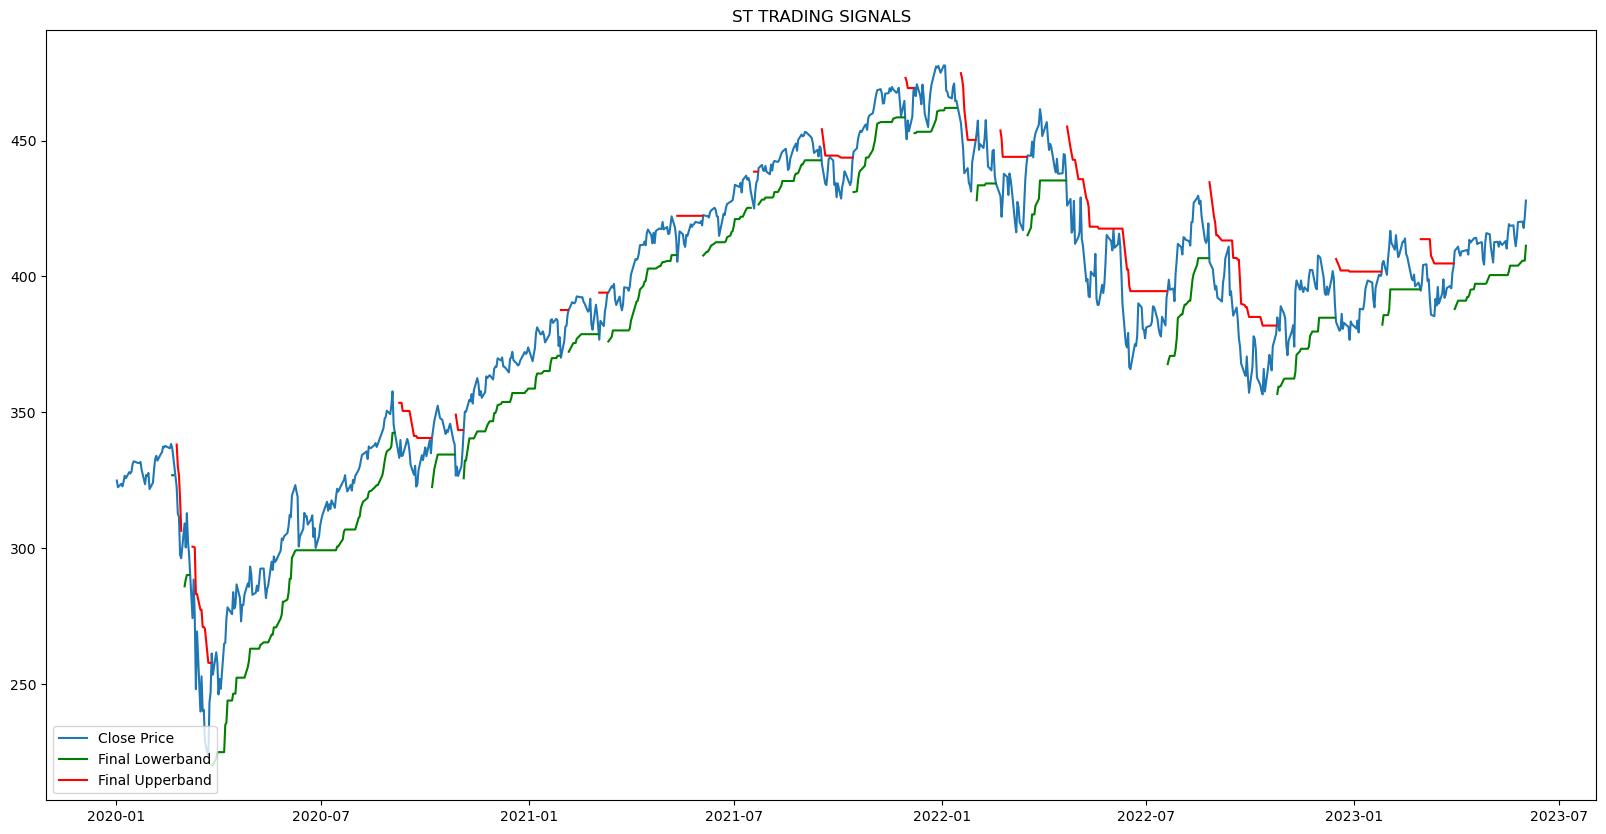

In [3]:
# visualization
#plt.figure(figsize = (14,10))
plt.figure(figsize=(20,10))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Final Lowerband'], 'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.title('ST TRADING SIGNALS')
plt.legend(loc = 'lower left')
plt.show()

In [4]:
def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend']
    close = df['Close']
    
    # initial condition
    in_position = False #倉位為 空
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []


    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        # 沒有倉位 及 價格處於上升 => 買入
        if not in_position and is_uptrend[i]:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
            print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
        

        # if in position & price is not on uptrend -> sell
        # 有倉位且價格低於上升趨勢 =>賣出
        elif in_position and not is_uptrend[i]:
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
            print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
            
    # if still in position -> sell all share
    # 賣出所有倉位
    if in_position:
        equity += share * close[i] - commission
    
    earning = equity - investment #盈餘
    roi = round(earning/investment*100,2) #投資報酬率
    print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')
    return entry, exit, equity

In [5]:
entry, exit, roi = backtest_supertrend(df, 100000)

Buy 300 shares at 323.64 on 2020/01/06
Sell at 322.42 on 2020/02/24
Buy 300 shares at 309.09 on 2020/03/02
Sell at 274.23 on 2020/03/09
Buy 300 shares at 261.2 on 2020/03/26
Sell at 333.21 on 2020/09/08
Buy 300 shares at 340.76 on 2020/10/07
Sell at 326.66 on 2020/10/28
Buy 300 shares at 343.54 on 2020/11/04
Sell at 370.07 on 2021/01/29
Buy 200 shares at 387.71 on 2021/02/05
Sell at 376.7 on 2021/03/04
Buy 200 shares at 394.06 on 2021/03/12
Sell at 405.41 on 2021/05/12
Buy 200 shares at 422.6 on 2021/06/04
Sell at 424.97 on 2021/07/19
Buy 200 shares at 439.94 on 2021/07/23
Sell at 441.4 on 2021/09/17
Buy 200 shares at 445.87 on 2021/10/15
Sell at 455.56 on 2021/11/30
Buy 200 shares at 469.52 on 2021/12/08
Sell at 456.49 on 2022/01/18
Buy 200 shares at 452.95 on 2022/02/01
Sell at 429.57 on 2022/02/22
Buy 200 shares at 444.52 on 2022/03/18
Sell at 426.04 on 2022/04/22
Buy 200 shares at 394.77 on 2022/07/20
Sell at 405.31 on 2022/08/26
Buy 200 shares at 384.92 on 2022/10/25
Sell at 383.2

In [6]:
def get_benchmark(start_date, investment_value):
    close = df['Close']
    benchmark = pd.DataFrame(np.diff(close)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/close[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)
investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('ST Strategy profit is {}% higher than the Benchmark Profit'.format(roi/100 - benchmark_profit_percentage), attrs = ['bold']))

Benchmark profit by investing $100k : 24010.65
Benchmark Profit percentage : 24%
ST Strategy profit is 1072.9899658203126% higher than the Benchmark Profit


In [7]:
import requests
url = 'https://www.slickcharts.com/sp500'
headers = {"User-Agent" : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'}

request = requests.get(url, headers = headers)

data = pd.read_html(request.text)[0]

# 欄位『Symbol』就是股票代碼
stock_list = data.Symbol

In [8]:
# get the full stock list of S&P 500
#payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
#stock_list = payload[0]['Symbol'].values.tolist()
supertrend_stocks = []
# loop through each symbol
for symbol in stock_list:
    df = yf.download(symbol, start='2000-01-01', threads= False)
    if len(df) == 0: continue
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    if not supertrend['Supertrend'][-2] and supertrend['Supertrend'][-1]:
        supertrend_stocks.append(symbol)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK.B: No timezone found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%******

In [9]:
supertrend_stocks

['ELV',
 'CAT',
 'BLK',
 'BDX',
 'MMM',
 'EMR',
 'TFC',
 'YUM',
 'OTIS',
 'ROK',
 'XYL',
 'EQR',
 'HBAN',
 'TAP',
 'CE',
 'JNPR',
 'CDAY']

In [10]:
for s in supertrend_stocks:
    print(s, end = ', ')

ELV, CAT, BLK, BDX, MMM, EMR, TFC, YUM, OTIS, ROK, XYL, EQR, HBAN, TAP, CE, JNPR, CDAY, 

In [11]:
def find_optimal_parameter(df):
    # predefine several parameter sets
    atr_period = [7, 8, 9, 10, 12, 18, 24, 28, 30, 34, 40]
    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
    roi_list = []
    
    # for each period and multiplier, perform backtest
    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:
        new_df = df
        supertrend = Supertrend(df, period, multiplier)
        new_df = df.join(supertrend)
        new_df = new_df[period:]
        entry, exit, roi = backtest_supertrend(new_df, 100000)
        roi_list.append((period, multiplier, roi))
    
    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))
    
    # return the best parameter set
    return max(roi_list, key=lambda x:x[2])

df = yf.download('spy', start='2020-01-01')
optimal_param = find_optimal_parameter(df)
print(f'Best parameter set: ATR Period={optimal_param[0]}, Multiplier={optimal_param[1]}, ROI={optimal_param[2]}%')

[*********************100%***********************]  1 of 1 completed
Buy 300 shares at 328.19 on 2020/01/15
Sell at 328.77 on 2020/01/24
Buy 300 shares at 327.68 on 2020/01/30
Sell at 321.73 on 2020/01/31
Buy 200 shares at 329.06 on 2020/02/04
Sell at 333.48 on 2020/02/21
Buy 300 shares at 309.09 on 2020/03/02
Sell at 297.46 on 2020/03/06
Buy 300 shares at 243.15 on 2020/03/24
Sell at 273.04 on 2020/04/21
Buy 300 shares at 287.05 on 2020/04/27
Sell at 282.79 on 2020/05/01
Buy 300 shares at 292.44 on 2020/05/08
Sell at 281.6 on 2020/05/13
Buy 300 shares at 295.0 on 2020/05/18
Sell at 300.61 on 2020/06/11
Buy 300 shares at 312.96 on 2020/06/16
Sell at 304.09 on 2020/06/24
Buy 300 shares at 310.52 on 2020/07/01
Sell at 320.88 on 2020/07/24
Buy 300 shares at 325.12 on 2020/07/29
Sell at 345.39 on 2020/09/03
Buy 300 shares at 334.19 on 2020/09/28
Sell at 342.01 on 2020/10/19
Buy 300 shares at 336.03 on 2020/11/03
Sell at 364.66 on 2020/12/14
Buy 300 shares at 372.24 on 2020/12/17
Sell at 36